In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

In [2]:
# Número de flip-flops para o código de sequência máxima
numFlipFlops = 6

# Número de símbolos transmitidos por iteração
numSimbolos = 1000 

# Intervalo de Eb/N0 em dB
Eb_N0_dB = np.arange(0, 24, 1) 

# Número de iterações para cada Eb/N0
numIteracoes = 10000 

# Comprimento do código de espalhamento
comprimentoCodigo = (2**numFlipFlops) - 1

# Modulação 8-PSK
M = 8
bitsPorSimbolo = int(np.log2(M))  # Bits por símbolo (3)

In [3]:
# Inicializando vetores de Registro de Deslocamento de Sequência Máxima
estadoReg = np.array([0, 1, 1, 1, 1, 1]) 
codigoBase = np.zeros(comprimentoCodigo)

# Gera o código de sequência máxima
for i in range(comprimentoCodigo):
    novoBit = (estadoReg[0] + estadoReg[5]) % 2
    estadoReg = np.roll(estadoReg, 1)
    estadoReg[0] = novoBit
    codigoBase[i] = estadoReg[5]

# Converte para {-1, +1} e normaliza para energia unitária
codigoBase = 2 * codigoBase - 1 
codigoBase /= np.sqrt(comprimentoCodigo) 

In [4]:
# Definição de parâmetros para simulação: 

# Atribuição de códigos aos usuários
codigoUsuario1 = codigoBase
codigoUsuario2 = np.roll(codigoBase, 5)
codigoUsuario3 = np.roll(codigoBase, 10)

# Inicializa vetor para BER, individual por usuário. 
BER_Usuario1 = np.zeros(len(Eb_N0_dB))
BER_Usuario2 = np.zeros(len(Eb_N0_dB))
BER_Usuario3 = np.zeros(len(Eb_N0_dB))

In [16]:
# laço de repetiação, para varrer todos os valores do vetor de SNR.
for idx, Eb_N0 in enumerate(Eb_N0_dB):

    # Cálculo da variância do ruído
    EbN0_linear = 10**(Eb_N0 / 10)
    sigma = np.sqrt(1 / (2 * bitsPorSimbolo * EbN0_linear))

    # Inicializa vetor para contagem de erros, individual por usuário
    numErros = np.zeros(3)
    numBitsTotal = numSimbolos * bitsPorSimbolo * numIteracoes


    # Laço de repetição, mantendo o valor de SNR e testando diversas interações
    for _ in range(numIteracoes):

        # Gera bits aleatórios para os usuários
        bitsUsuarios = np.random.randint(0, 2, (3, numSimbolos * bitsPorSimbolo))
        simbolos = np.exp(1j * 2 * np.pi * np.dot(bitsUsuarios.reshape(3, -1, bitsPorSimbolo), (2**np.arange(bitsPorSimbolo)[::-1])) / M)

        # Transmissão e recepção
        TX_total = sum(np.outer(codigoBase, simbolos[i, :]).flatten() for i, codigoBase in enumerate([codigoUsuario1, codigoUsuario2, codigoUsuario3]))
        RX_total = TX_total + sigma * (np.random.randn(*TX_total.shape) + 1j * np.random.randn(*TX_total.shape))
        RX_matriz = RX_total.reshape(comprimentoCodigo, numSimbolos)

        # Desespalhamento e decisão de símbolos
        for i, codigoBase in enumerate([codigoUsuario1, codigoUsuario2, codigoUsuario3]):
            
            # Verifica se o código do usuário está presente
            sinaisDesespalhados = np.sum(RX_matriz * codigoBase[:, None], axis=0)
            fasesRecebidas = np.angle(sinaisDesespalhados)
            decisao = np.round(fasesRecebidas / (2 * np.pi / M)) % M
    
            # Converter símbolos para bits corretamente
            bitsRecebidos = np.array([list(np.binary_repr(int(d), width=bitsPorSimbolo)) for d in decisao], dtype=int).flatten()
    
             # Comparar apenas os bits relevantes
            numErros[i] += np.sum(bitsRecebidos[:len(bitsUsuarios[i, :])] != bitsUsuarios[i, :])


    # Cálculo da BER para cada usuário
    BER_Usuario1[idx], BER_Usuario2[idx], BER_Usuario3[idx] = numErros / numBitsTotal

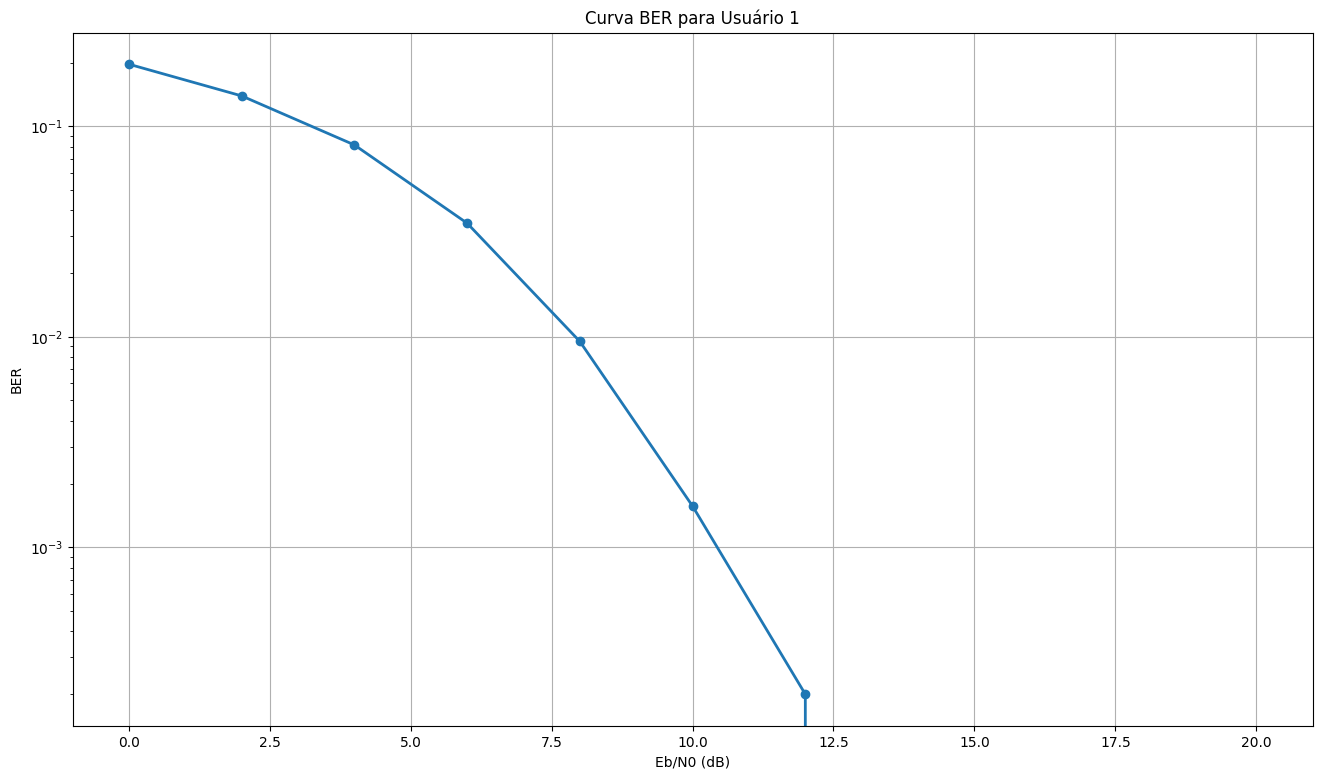

In [17]:
# Plot da Curva BER para o Usuário 1
plt.figure(figsize=(16,9))
plt.semilogy(Eb_N0_dB, BER_Usuario1, 'o-', linewidth=2)
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('BER')
plt.title('Curva BER para Usuário 1')
plt.grid(True)
plt.show()

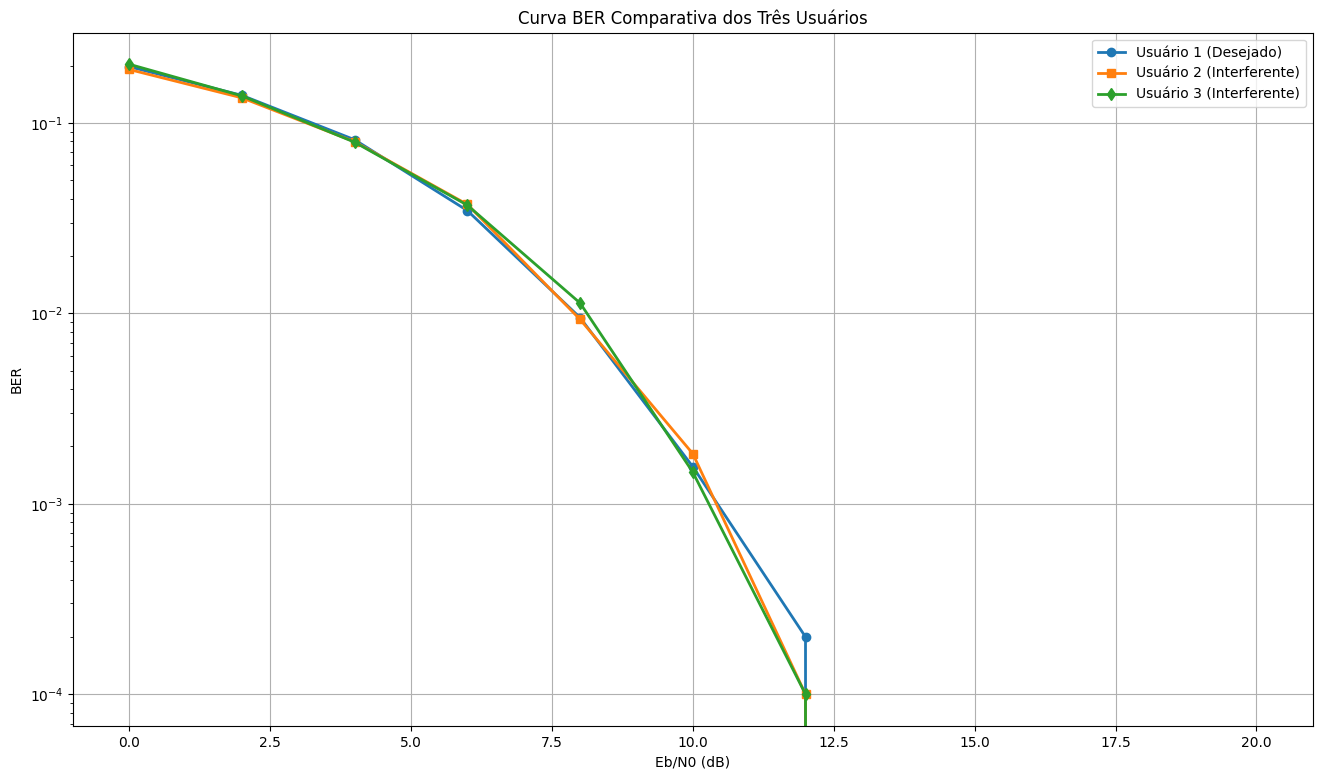

In [18]:
# Plot Comparativo BER para os Três Usuários
plt.figure(figsize=(16,9))
plt.semilogy(Eb_N0_dB, BER_Usuario1, 'o-', linewidth=2, label='Usuário 1 (Desejado)')
plt.semilogy(Eb_N0_dB, BER_Usuario2, 's-', linewidth=2, label='Usuário 2 (Interferente)')
plt.semilogy(Eb_N0_dB, BER_Usuario3, 'd-', linewidth=2, label='Usuário 3 (Interferente)')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('BER')
plt.title('Curva BER Comparativa dos Três Usuários')
plt.legend()
plt.grid(True)
plt.show()